# Análisis Final, Cuellos de Botella V.1

Se procede a realizar el análisis final del proyecto, en donde se incorporarán las demás zonas operacionales que quedan pendientes.
Las tareas pendientes son: 

1. Analizar el tiempo promedio, min y máx para los tiempos de espera antes de entrar a la cancha.
2. Calcular el tiempo de espera perdido utilizando el tiempo calculado anteriormente.
3. Analizar las zonas restantes teniendo en cuenta el producto, origen, destino.

__pd el dataset de colas tiene el filtro de las colas inferiores a 3 hrs__
# Analizar el tiempo ideal antes de entrar a la cancha

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns
from manager_propio import *

In [2]:
cols = ['Total Time','Datei','Datef','Ti','Tf']

#Cargamos el dataset de actividades
actividad = pd.read_csv('actividad_v2.csv')
actividad = actividad.drop('Unnamed: 0',axis=1)
#actividad = actividad.drop(cols,axis=1)
actividad['Start Act'] = pd.to_datetime(actividad['Start Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['End Act'] = pd.to_datetime(actividad['End Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['date start'] = pd.to_datetime(actividad['Start Act']).dt.date
actividad['date end'] = pd.to_datetime(actividad['End Act']).dt.date
actividad['time start'] = pd.to_datetime(actividad['Start Act']).dt.time
actividad['time end'] = pd.to_datetime(actividad['End Act']).dt.time
actividad['Day of year [In]'] = pd.to_datetime(actividad['Start Act']).dt.dayofyear
actividad['Day of year [Out]'] = pd.to_datetime(actividad['End Act']).dt.dayofyear
actividad['time Act'] = ((actividad['End Act']) - pd.to_datetime(actividad['Start Act']))/np.timedelta64(1, 's')

#cargamos el dataset de las colas antiguas
colas_old = pd.read_csv('colas.csv')
colas_old = colas_old.drop('Unnamed: 0',axis=1)
colas_old['Start Cola'] = pd.to_datetime(colas_old['Start Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['End Cola'] = pd.to_datetime(colas_old['End Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['date start'] = pd.to_datetime(colas_old['Start Cola']).dt.date
colas_old['date end'] = pd.to_datetime(colas_old['End Cola']).dt.date
colas_old['time start'] = pd.to_datetime(colas_old['Start Cola']).dt.time
colas_old['time end'] = pd.to_datetime(colas_old['End Cola']).dt.time
colas_old['Day of year [In]'] = pd.to_datetime(colas_old['Start Cola']).dt.dayofyear
colas_old['Day of year [Out]'] = pd.to_datetime(colas_old['End Cola']).dt.dayofyear
colas_old['time cola'] = ((colas_old['End Cola']) - pd.to_datetime(colas_old['Start Cola']))/np.timedelta64(1, 's')

#Filtramos por el termino de las 3 hrs
colas_old = colas_old[(colas_old['time cola'] < 10800) & (colas_old['time cola'] > 0)]  #timepos mayores a 0 minutos y menores a 3 hrs


#Cargamos el dataset de las nuevas colas. con el filtro de las 3 horas
colas = pd.read_csv("colas_filtradas_v2.csv")  #ya tiene las horas cambiadas
colas = colas.drop('Unnamed: 0',axis=1)
colas['Start Cola'] = pd.to_datetime(colas['Start Cola'])
colas['End Cola'] = pd.to_datetime(colas['End Cola'])


## Partimos analizando 1 trayecto en paticular, NV-CS

Recordamos que colas tienen el filtro de las 3 hrs.

Buscaremos un tiempo ideal o mínimo, esto debería darse en la madrugada, por lo que filtraremos desde las 0 hrs a las 3 hrs.

In [3]:
nv_cs = actividad[(actividad['Origin'] == 'Nueva Victoria') & (actividad['time start'] <= datetime.time(3,0,0)) & 
                  (actividad['Day of year [In]'] <= 365)]
filter_1 = nv_cs.sort_values(['ID','Day of year [In]','time start']).iloc[2:,:]
filter_1

ID          Origin Destination Product              ZO  \
163197  10048832  Nueva Victoria    Coya Sur    SNIT          C NPT3   
52336   10048832  Nueva Victoria    Coya Sur    SNIT          Salida   
163337  10049005  Nueva Victoria    Coya Sur    SNIT          C NPT3   
52489   10049005  Nueva Victoria    Coya Sur    SNIT          Salida   
163492  10049171  Nueva Victoria    Coya Sur    SNIT          C NPT3   
...          ...             ...         ...     ...             ...   
256798   9802963  Nueva Victoria    Coya Sur    SNIT       C Prilado   
244012   9802963  Nueva Victoria    Coya Sur    SNIT  Romana Salitre   
136812   9802963  Nueva Victoria    Coya Sur    SNIT          Salida   
153273   9828386  Nueva Victoria    Coya Sur    SNIT          C CS-4   
86042    9828386  Nueva Victoria    Coya Sur    SNIT          Salida   

                       Start Act                   End Act  Pre Time  \
163197 2019-07-04 01:59:32-04:00 2019-07-04 02:08:32-04:00     741.0   
52336  2019-07-04 02:08:32-04:00 2019-07-04 02:14:33-04:00       0.0   
163337 2019-07-05 02:23:04-04:00 2019-07-05 02:29:04-04:00    1460.0   
52489  2019-07-05 02:29:04-04:00 2019-07-05 02:36:05-04:00       0.0   
163492 2019-07-06 01:47:33-04:00 2019-07-06 01:54:34-04:00     900.0   
...                          ...                       ...       ...   
256798 2019-10-01 00:56:12-03:00 2019-10-01 01:10:11-03:00     840.0   
244012 2019-10-01 01:13:11-03:00 2019-10-01 01:22:11-03:00     180.0   
136812 2019-10-01 01:22:11-03:00 2019-10-01 01:37:15-03:00       0.0   
153273 2020-01-05 02:48:50-03:00 2020-01-05 02:55:50-03:00    1193.0   
86042  2020-01-05 02:55:50-03:00 2020-01-05 03:03:49-03:00       0.0   

        date start    date end time start  time end  Day of year [In]  \
163197  2019-07-04  2019-07-04   01:59:32  02:08:32               185   
52336   2019-07-04  2019-07-04   02:08:32  02:14:33               185   
163337  2019-07-05  2019-07-05   02:23:04  02:29:04               186   
52489   2019-07-05  2019-07-05   02:29:04  02:36:05               186   
163492  2019-07-06  2019-07-06   01:47:33  01:54:34               187   
...            ...         ...        ...       ...               ...   
256798  2019-10-01  2019-10-01   00:56:12  01:10:11               274   
244012  2019-10-01  2019-10-01   01:13:11  01:22:11               274   
136812  2019-10-01  2019-10-01   01:22:11  01:37:15               274   
153273  2020-01-05  2020-01-05   02:48:50  02:55:50                 5   
86042   2020-01-05  2020-01-05   02:55:50  03:03:49                 5   

        Day of year [Out]  time Act  
163197                185     540.0  
52336                 185     361.0  
163337                186     360.0  
52489                 186     421.0  
163492                187     421.0  
...                   ...       ...  
256798                274     839.0  
244012                274     540.0  
136812                274     904.0  
153273                  5     420.0  
86042                   5     479.0  

[4980 rows x 15 columns]

Aquí tenemos 10 camiones en distintos días que estan solos en la cola, es decir no se encuentran con Nadie.
Podemos notar en la columna de Pretime cuando vienen desde la Entrada, son los valores distintos de 0

In [4]:
# Trayecto desde la entrada a la primera ZO.
filter_1[(filter_1['ZO'] != 'Salida')  & (filter_1['Pre Time'] <= 1500)]

ID          Origin Destination Product              ZO  \
163197  10048832  Nueva Victoria    Coya Sur    SNIT          C NPT3   
163337  10049005  Nueva Victoria    Coya Sur    SNIT          C NPT3   
163492  10049171  Nueva Victoria    Coya Sur    SNIT          C NPT3   
163705  10049342  Nueva Victoria    Coya Sur    SNIT          C NPT3   
163993  10049665  Nueva Victoria    Coya Sur    SNIT          C NPT3   
...          ...             ...         ...     ...             ...   
145431   9801589  Nueva Victoria    Coya Sur    SNIT           C PTS   
233078   9802963  Nueva Victoria    Coya Sur    SNIT  Romana Salitre   
256798   9802963  Nueva Victoria    Coya Sur    SNIT       C Prilado   
244012   9802963  Nueva Victoria    Coya Sur    SNIT  Romana Salitre   
153273   9828386  Nueva Victoria    Coya Sur    SNIT          C CS-4   

                       Start Act                   End Act  Pre Time  \
163197 2019-07-04 01:59:32-04:00 2019-07-04 02:08:32-04:00     741.0   
163337 2019-07-05 02:23:04-04:00 2019-07-05 02:29:04-04:00    1460.0   
163492 2019-07-06 01:47:33-04:00 2019-07-06 01:54:34-04:00     900.0   
163705 2019-07-07 01:48:40-04:00 2019-07-07 01:55:40-04:00     596.0   
163993 2019-07-09 01:28:44-04:00 2019-07-09 01:33:44-04:00     566.0   
...                          ...                       ...       ...   
145431 2019-09-25 02:38:38-03:00 2019-09-25 02:47:29-03:00    1007.0   
233078 2019-10-01 00:33:13-03:00 2019-10-01 00:42:12-03:00     240.0   
256798 2019-10-01 00:56:12-03:00 2019-10-01 01:10:11-03:00     840.0   
244012 2019-10-01 01:13:11-03:00 2019-10-01 01:22:11-03:00     180.0   
153273 2020-01-05 02:48:50-03:00 2020-01-05 02:55:50-03:00    1193.0   

        date start    date end time start  time end  Day of year [In]  \
163197  2019-07-04  2019-07-04   01:59:32  02:08:32               185   
163337  2019-07-05  2019-07-05   02:23:04  02:29:04               186   
163492  2019-07-06  2019-07-06   01:47:33  01:54:34               187   
163705  2019-07-07  2019-07-07   01:48:40  01:55:40               188   
163993  2019-07-09  2019-07-09   01:28:44  01:33:44               190   
...            ...         ...        ...       ...               ...   
145431  2019-09-25  2019-09-25   02:38:38  02:47:29               268   
233078  2019-10-01  2019-10-01   00:33:13  00:42:12               274   
256798  2019-10-01  2019-10-01   00:56:12  01:10:11               274   
244012  2019-10-01  2019-10-01   01:13:11  01:22:11               274   
153273  2020-01-05  2020-01-05   02:48:50  02:55:50                 5   

        Day of year [Out]  time Act  
163197                185     540.0  
163337                186     360.0  
163492                187     421.0  
163705                188     420.0  
163993                190     300.0  
...                   ...       ...  
145431                268     531.0  
233078                274     539.0  
256798                274     839.0  
244012                274     540.0  
153273                  5     420.0  

[1946 rows x 15 columns]

In [5]:
filter_1[(filter_1['ZO'] != 'Salida') & (filter_1['Pre Time'] <= 1000)].describe()

Pre Time  Day of year [In]  Day of year [Out]     time Act
count  1337.000000        1337.00000         1337.00000  1337.000000
mean    619.689604         180.94914          180.94914   481.646223
std     314.669609          94.95356           94.95356   443.891740
min     -61.000000           1.00000            1.00000   120.000000
25%     405.000000         103.00000          103.00000   300.000000
50%     725.000000         158.00000          158.00000   363.000000
75%     868.000000         260.00000          260.00000   532.000000
max    1000.000000         365.00000          365.00000  8044.000000

In [6]:
filter_1[(filter_1['ZO'] == 'Salida')].describe()

Pre Time  Day of year [In]  Day of year [Out]     time Act
count    2297.0       2297.000000        2297.000000  2297.000000
mean        0.0        191.034828         191.034828   456.608185
std         0.0        102.540578         102.540578   422.825481
min         0.0          1.000000           1.000000   120.000000
25%         0.0        107.000000         107.000000   280.000000
50%         0.0        198.000000         198.000000   420.000000
75%         0.0        274.000000         274.000000   504.000000
max         0.0        365.000000         365.000000  7721.000000

__De este análisis podemos extraer lo siguiente:__

1. El tiempo ideal o mínimo de entrada a la faena y llegada a la primera cancha es de 725 segundos, es decir: __12 minutos.__
2. El tiempo ideal en la zona operacional (NPT3, NPT4) para este trayecto son de  363 segundos, es decir: __6 minutos.__
3. El tiempo ideal o mínimo para la salida de estos vehículos, desde la ZO a la salida es de 450 segundos, es decir: __7,5 minutos__

Por tanto el vehículo debe estar en la faena alrededor de __26 minutos, en un trayecto ideal para NV-CS__.

Esto indica que tomar 15 minutos para el tiempo ideal de espera es poco, pero no está tan alejado de la realidad, ya que el tiempo mínimo es de 13 minutos, en un escenario ideal.

Si consideramos un escenario más realista, se esperaría que cada camión tuviese 2 camiones adelante de el, es decir solamente 3 en cola, por lo que este último debería esperar la acción de estos 2 camiones que le anteceden, considerando que la actividad es de 6 minutos por camión tenemos un total de 12 minutos adicionales, a esto hay que sumar el tiempo adicional en que el camionero debe bajar y subir por temas de guías o intrucciones en lo que sumamos un tiempo de 3 minutos por camión adicional, es decir sumamos 6 minutos adicionales, quedándonos con un tiempo de espera para el 3er camión de __12+2x6+2x3 = 30 minutos__

pd: estamos tomando el 50% de los datos para calcular los ptos 1,2 debido al sesgo de las multiples canchas que puede haber y para la salida (pto 3) solo ocupamos el promedio ya que no hay sesgo

### Realizaremos el mismo análisis para los viajes de Salar Coya

In [7]:
sa_cs = actividad[(actividad['Origin'] == 'Salar de Atacama') & (actividad['time start'] <= datetime.time(3,0,0)) ]
filter_2 = sa_cs.sort_values(['ID','Day of year [In]','time start']).iloc[2:,:]
filter_2

ID            Origin Destination    Product      ZO  \
171330  10011973  Salar de Atacama    Coya Sur   MOP-H-BL  C NPT3   
62373   10011973  Salar de Atacama    Coya Sur   MOP-H-BL  Salida   
173616  10012507  Salar de Atacama    Coya Sur   MOP-H-BL  C NPT3   
66291   10012507  Salar de Atacama    Coya Sur   MOP-H-BL  Salida   
181522  10014126  Salar de Atacama    Coya Sur   MOP-H-BL  C NPT3   
...          ...               ...         ...        ...     ...   
59510    9990540  Salar de Atacama    Coya Sur  SILVINITA  Salida   
167060   9990578  Salar de Atacama    Coya Sur  SILVINITA  C NPT3   
56883    9990578  Salar de Atacama    Coya Sur  SILVINITA  Salida   
173985   9994933  Salar de Atacama    Coya Sur   MOP-H-BL  C NPT3   
66767    9994933  Salar de Atacama    Coya Sur   MOP-H-BL  Salida   

                       Start Act                   End Act  Pre Time  \
171330 2019-08-30 00:29:20-04:00 2019-08-30 00:45:07-04:00     921.0   
62373  2019-08-30 00:45:07-04:00 2019-08-30 00:50:47-04:00       0.0   
173616 2019-09-19 01:58:41-03:00 2019-09-19 02:07:41-03:00     757.0   
66291  2019-09-19 02:07:41-03:00 2019-09-19 02:13:33-03:00       0.0   
181522 2019-11-17 02:57:33-03:00 2019-11-17 03:02:50-03:00     613.0   
...                          ...                       ...       ...   
59510  2019-08-14 01:06:51-04:00 2019-08-14 01:15:52-04:00       0.0   
167060 2019-07-30 02:31:36-04:00 2019-07-30 02:38:31-04:00    1898.0   
56883  2019-07-30 02:38:31-04:00 2019-07-30 02:46:01-04:00       0.0   
173985 2019-09-21 02:30:19-03:00 2019-09-21 02:39:34-03:00     804.0   
66767  2019-09-21 02:39:34-03:00 2019-09-21 02:58:51-03:00       0.0   

        date start    date end time start  time end  Day of year [In]  \
171330  2019-08-30  2019-08-30   00:29:20  00:45:07               242   
62373   2019-08-30  2019-08-30   00:45:07  00:50:47               242   
173616  2019-09-19  2019-09-19   01:58:41  02:07:41               262   
66291   2019-09-19  2019-09-19   02:07:41  02:13:33               262   
181522  2019-11-17  2019-11-17   02:57:33  03:02:50               321   
...            ...         ...        ...       ...               ...   
59510   2019-08-14  2019-08-14   01:06:51  01:15:52               226   
167060  2019-07-30  2019-07-30   02:31:36  02:38:31               211   
56883   2019-07-30  2019-07-30   02:38:31  02:46:01               211   
173985  2019-09-21  2019-09-21   02:30:19  02:39:34               264   
66767   2019-09-21  2019-09-21   02:39:34  02:58:51               264   

        Day of year [Out]  time Act  
171330                242     947.0  
62373                 242     340.0  
173616                262     540.0  
66291                 262     352.0  
181522                321     317.0  
...                   ...       ...  
59510                 226     541.0  
167060                211     415.0  
56883                 211     450.0  
173985                264     555.0  
66767                 264    1157.0  

[1613 rows x 15 columns]

In [8]:
# Trayecto desde la entrada a la primera ZO.
filter_2[(filter_2['ZO'] != 'Salida')].iloc[:10,:]

ID            Origin Destination    Product         ZO  \
171330  10011973  Salar de Atacama    Coya Sur   MOP-H-BL     C NPT3   
173616  10012507  Salar de Atacama    Coya Sur   MOP-H-BL     C NPT3   
181522  10014126  Salar de Atacama    Coya Sur   MOP-H-BL     C NPT3   
148732  10043548  Salar de Atacama    Coya Sur   MOP-H-BL     C CS-4   
178577  10043585  Salar de Atacama    Coya Sur  SILVINITA     C NPT3   
180980  10044215  Salar de Atacama    Coya Sur   MOP-H-BL     C NPT3   
23587   10044658  Salar de Atacama    Coya Sur   MOP-H-BL  C NPT 1-2   
154769  10051019  Salar de Atacama    Coya Sur   MOP-H-BL     C CS-4   
170609  10078811  Salar de Atacama    Coya Sur   MOP-H-BL     C NPT3   
170728  10078853  Salar de Atacama    Coya Sur   MOP-H-BL     C NPT3   

                       Start Act                   End Act  Pre Time  \
171330 2019-08-30 00:29:20-04:00 2019-08-30 00:45:07-04:00     921.0   
173616 2019-09-19 01:58:41-03:00 2019-09-19 02:07:41-03:00     757.0   
181522 2019-11-17 02:57:33-03:00 2019-11-17 03:02:50-03:00     613.0   
148732 2019-10-21 01:22:16-03:00 2019-10-21 01:28:05-03:00     989.0   
178577 2019-10-22 01:17:11-03:00 2019-10-22 01:21:40-03:00     569.0   
180980 2019-11-14 02:56:00-03:00 2019-11-14 03:02:40-03:00    1512.0   
23587  2019-11-26 00:31:27-03:00 2019-11-26 00:37:09-03:00    1331.0   
154769 2020-02-06 00:52:06-03:00 2020-02-06 00:59:07-03:00   25310.0   
170609 2019-08-23 01:53:11-04:00 2019-08-23 01:58:51-04:00    2662.0   
170728 2019-08-24 02:57:49-04:00 2019-08-24 03:05:49-04:00     601.0   

        date start    date end time start  time end  Day of year [In]  \
171330  2019-08-30  2019-08-30   00:29:20  00:45:07               242   
173616  2019-09-19  2019-09-19   01:58:41  02:07:41               262   
181522  2019-11-17  2019-11-17   02:57:33  03:02:50               321   
148732  2019-10-21  2019-10-21   01:22:16  01:28:05               294   
178577  2019-10-22  2019-10-22   01:17:11  01:21:40               295   
180980  2019-11-14  2019-11-14   02:56:00  03:02:40               318   
23587   2019-11-26  2019-11-26   00:31:27  00:37:09               330   
154769  2020-02-06  2020-02-06   00:52:06  00:59:07                37   
170609  2019-08-23  2019-08-23   01:53:11  01:58:51               235   
170728  2019-08-24  2019-08-24   02:57:49  03:05:49               236   

        Day of year [Out]  time Act  
171330                242     947.0  
173616                262     540.0  
181522                321     317.0  
148732                294     349.0  
178577                295     269.0  
180980                318     400.0  
23587                 330     342.0  
154769                 37     421.0  
170609                235     340.0  
170728                236     480.0

Tiempo de llegada a la ZO desde la entrada (Pre Time) y tiempo de actividad en la ZO (Time Act)

In [9]:
filter_2[(filter_2['ZO'] != 'Salida') & (filter_2['Pre Time'] <= 1500 )].describe()

Pre Time  Day of year [In]  Day of year [Out]     time Act
count   488.000000        488.000000         488.000000   488.000000
mean    815.147541        180.635246         180.635246   575.290984
std     364.275657        101.045470         101.045470   434.638297
min       0.000000          2.000000           2.000000   120.000000
25%     630.000000        110.000000         110.000000   400.500000
50%     827.500000        190.500000         190.500000   477.000000
75%    1038.500000        266.000000         266.000000   599.000000
max    1500.000000        364.000000         364.000000  6054.000000

Tiempo desde la ZO hasta la salida (time act)

In [10]:
filter_2[(filter_2['ZO'] == 'Salida')].describe()

Pre Time  Day of year [In]  Day of year [Out]      time Act
count     725.0        725.000000         725.000000    725.000000
mean        0.0        170.816552         170.816552    885.924138
std         0.0         98.868269          98.868269   2236.017970
min         0.0          2.000000           2.000000    119.000000
25%         0.0        109.000000         109.000000    381.000000
50%         0.0        152.000000         152.000000    480.000000
75%         0.0        253.000000         253.000000   1021.000000
max         0.0        364.000000         364.000000  35884.000000

__De este análisis podemos extraer lo siguiente:__

1. El tiempo ideal o mínimo de entrada a la faena y llegada a la primera cancha es de 827 segundos, es decir: __14 minutos.__
2. El tiempo ideal en la zona operacional (NPT3, NPT4) para este trayecto son de  480 segundos, es decir: __8 minutos.__
3. El tiempo ideal o mínimo para la salida de estos vehículos, desde la ZO a la salida es de 885 segundos, es decir: __14 minutos__

Por tanto el vehículo debe estar en la faena alrededor de __36 minutos, en un trayecto ideal para SA-CS__.

Si consideramos un escenario más realista, se esperaría que cada camión tuviese 2 camiones adelante de el, es decir solamente 3 en cola, por lo que este último debería esperar la acción de estos 2 camiones que le anteceden, considerando que la actividad es de 8 minutos por camión tenemos un total de 16 minutos adicionales, a esto hay que sumar el tiempo adicional en que el camionero debe bajar y subir por temas de guías o intrucciones en lo que sumamos un tiempo de 3 minutos por camión adicional, es decir sumamos 6 minutos adicionales, quedándonos con un tiempo de espera para el 3er camión de __14+2x8+2x3 = 36 minutos__

### Realizaremos el mismo análisis para los viajes desde Coya

In [11]:
aux = actividad[(actividad['Origin'] == 'Coya Sur') & (actividad['time start'] <= datetime.time(3,0,0)) ]
filter_3 = aux.sort_values(['ID','Day of year [In]','time start','Product']).iloc[2:,:]
filter_3

ID    Origin       Destination      Product              ZO  \
226202  10129194  Coya Sur         Tocopilla        SSA-J  Romana Salitre   
254467  10129194  Coya Sur         Tocopilla        SSA-J       C Prilado   
254527  10129278  Coya Sur         Tocopilla        SSA-J       C Prilado   
38311   10129278  Coya Sur         Tocopilla        SSA-J        Romana 3   
17702   10130522  Coya Sur    Puerto Angamos  NPC-R SOLAR   Losa Envasado   
...          ...       ...               ...          ...             ...   
58315    9983327  Coya Sur  Salar de Atacama          NaN          Salida   
18668    9987680  Coya Sur  Salar de Atacama          NaN           C ATM   
51918    9987680  Coya Sur  Salar de Atacama          NaN          Salida   
162919   9987718  Coya Sur  Salar de Atacama          NaN          C NPT3   
52052    9987718  Coya Sur  Salar de Atacama          NaN          Salida   

                       Start Act                   End Act  Pre Time  \
226202 2020-01-06 02:11:03-03:00 2020-01-06 02:18:03-03:00  572180.0   
254467 2020-01-06 02:21:03-03:00 2020-01-06 04:04:59-03:00     180.0   
254527 2020-01-09 02:02:10-03:00 2020-01-09 02:53:14-03:00   31016.0   
38311  2020-01-09 02:55:06-03:00 2020-01-09 03:13:57-03:00     112.0   
17702  2020-02-11 02:35:37-03:00 2020-02-11 03:01:43-03:00   32223.0   
...                          ...                       ...       ...   
58315  2019-08-07 00:03:58-04:00 2019-08-07 00:07:59-04:00       0.0   
18668  2019-07-01 00:43:06-04:00 2019-07-01 00:52:07-04:00     695.0   
51918  2019-07-01 00:52:07-04:00 2019-07-01 01:01:09-04:00       0.0   
162919 2019-07-02 00:48:04-04:00 2019-07-02 00:57:21-04:00     873.0   
52052  2019-07-02 00:57:21-04:00 2019-07-02 01:03:07-04:00       0.0   

        date start    date end time start  time end  Day of year [In]  \
226202  2020-01-06  2020-01-06   02:11:03  02:18:03                 6   
254467  2020-01-06  2020-01-06   02:21:03  04:04:59                 6   
254527  2020-01-09  2020-01-09   02:02:10  02:53:14                 9   
38311   2020-01-09  2020-01-09   02:55:06  03:13:57                 9   
17702   2020-02-11  2020-02-11   02:35:37  03:01:43                42   
...            ...         ...        ...       ...               ...   
58315   2019-08-07  2019-08-07   00:03:58  00:07:59               219   
18668   2019-07-01  2019-07-01   00:43:06  00:52:07               182   
51918   2019-07-01  2019-07-01   00:52:07  01:01:09               182   
162919  2019-07-02  2019-07-02   00:48:04  00:57:21               183   
52052   2019-07-02  2019-07-02   00:57:21  01:03:07               183   

        Day of year [Out]  time Act  
226202                  6     420.0  
254467                  6    6236.0  
254527                  9    3064.0  
38311                   9    1131.0  
17702                  42    1566.0  
...                   ...       ...  
58315                 219     241.0  
18668                 182     541.0  
51918                 182     542.0  
162919                183     557.0  
52052                 183     346.0  

[7714 rows x 15 columns]

In [12]:
filter_3[(filter_3['ZO'] != 'Salida')  & (filter_3['Pre Time'] <= 1500)].describe()

Pre Time  Day of year [In]  Day of year [Out]      time Act
count  4581.000000       4581.000000        4581.000000   4581.000000
mean    449.432220        168.431347         168.431347    663.802227
std     410.666928        112.546739         112.546739    759.428439
min     -87.000000          1.000000           1.000000    120.000000
25%     107.000000         79.000000          79.000000    347.000000
50%     299.000000        128.000000         128.000000    457.000000
75%     763.000000        288.000000         288.000000    705.000000
max    1500.000000        365.000000         365.000000  16097.000000

In [13]:
filter_3[(filter_3['ZO'] == 'Salida')].describe()

Pre Time  Day of year [In]  Day of year [Out]       time Act
count    1982.0       1982.000000        1982.000000    1982.000000
mean        0.0        169.452573         169.453078     996.218466
std         0.0        103.921871         103.922512    3609.762346
min         0.0          1.000000           1.000000      43.000000
25%         0.0         90.000000          90.000000     390.500000
50%         0.0        138.000000         138.000000     540.000000
75%         0.0        269.000000         269.000000     873.000000
max         0.0        365.000000         365.000000  114450.000000

__De este análisis podemos extraer lo siguiente:__

1. El tiempo ideal o mínimo de entrada a la faena y llegada a la primera cancha es de 763 segundos, es decir: __13 minutos.__
2. El tiempo ideal en la zona operacional para este trayecto son de  457 segundos, es decir: __8 minutos.__
3. El tiempo ideal o mínimo para la salida de estos vehículos, desde la ZO a la salida es de 873 segundos, es decir: __15 minutos__

Por tanto el vehículo debe estar en la faena alrededor de __36 minutos, en un trayecto ideal desde CS__.

Si consideramos un escenario más realista, se esperaría que cada camión tuviese 2 camiones adelante de el, es decir solamente 3 en cola, por lo que este último debería esperar la acción de estos 2 camiones que le anteceden, considerando que la actividad es de 8 minutos por camión tenemos un total de 16 minutos adicionales, a esto hay que sumar el tiempo adicional en que el camionero debe bajar y subir por temas de guías o intrucciones en lo que sumamos un tiempo de 3 minutos por camión adicional, es decir sumamos 6 minutos adicionales, quedándonos con un tiempo de espera para el 3er camión de __13+2x8+2x3 = 35 minutos__

### Realizaremos el mismo análisis para los viajes Tocopilla - CS

In [14]:
aux = actividad[(actividad['Origin'] == 'Tocopilla') & (actividad['time start'] <= datetime.time(3,0,0)) ]
filter_4 = aux.sort_values(['ID','Day of year [In]','time start','Product']).iloc[2:,:]
filter_4

ID     Origin Destination Product              ZO  \
233214  10007500  Tocopilla    Coya Sur     NaN  Romana Salitre   
256848  10007500  Tocopilla    Coya Sur     NaN       C Prilado   
26727   10029442  Tocopilla    Coya Sur     NaN        Romana 3   
26783   10029494  Tocopilla    Coya Sur     NaN        Romana 3   
9339    10029494  Tocopilla    Coya Sur     NaN    C Secado L-4   
...          ...        ...         ...     ...             ...   
245655   9948487  Tocopilla    Coya Sur     NaN  Romana Salitre   
140104   9948487  Tocopilla    Coya Sur     NaN          Salida   
1193     9949719  Tocopilla    Coya Sur     NaN    C Secado L-4   
232045   9949719  Tocopilla    Coya Sur     NaN  Romana Salitre   
114421   9949719  Tocopilla    Coya Sur     NaN          Salida   

                       Start Act                   End Act  Pre Time  \
233214 2019-10-10 02:40:06-03:00 2019-10-10 02:49:06-03:00   44566.0   
256848 2019-10-10 02:55:02-03:00 2019-10-10 04:59:07-03:00     356.0   
26727  2020-02-20 02:23:24-03:00 2020-02-20 02:25:58-03:00     240.0   
26783  2020-02-21 02:30:12-03:00 2020-02-21 02:34:16-03:00     232.0   
9339   2020-02-21 02:38:55-03:00 2020-02-21 02:52:18-03:00     279.0   
...                          ...                       ...       ...   
245655 2019-08-15 02:26:46-04:00 2019-08-15 02:58:09-04:00     209.0   
140104 2019-08-15 02:58:09-04:00 2019-08-15 03:14:23-04:00       0.0   
1193   2019-09-05 01:10:32-04:00 2019-09-05 01:16:32-04:00   31793.0   
232045 2019-09-05 01:20:31-04:00 2019-09-05 01:30:25-04:00     239.0   
114421 2019-09-05 01:30:25-04:00 2019-09-05 01:45:20-04:00       0.0   

        date start    date end time start  time end  Day of year [In]  \
233214  2019-10-10  2019-10-10   02:40:06  02:49:06               283   
256848  2019-10-10  2019-10-10   02:55:02  04:59:07               283   
26727   2020-02-20  2020-02-20   02:23:24  02:25:58                51   
26783   2020-02-21  2020-02-21   02:30:12  02:34:16                52   
9339    2020-02-21  2020-02-21   02:38:55  02:52:18                52   
...            ...         ...        ...       ...               ...   
245655  2019-08-15  2019-08-15   02:26:46  02:58:09               227   
140104  2019-08-15  2019-08-15   02:58:09  03:14:23               227   
1193    2019-09-05  2019-09-05   01:10:32  01:16:32               248   
232045  2019-09-05  2019-09-05   01:20:31  01:30:25               248   
114421  2019-09-05  2019-09-05   01:30:25  01:45:20               248   

        Day of year [Out]  time Act  
233214                283     540.0  
256848                283    7445.0  
26727                  51     154.0  
26783                  52     244.0  
9339                   52     803.0  
...                   ...       ...  
245655                227    1883.0  
140104                227     974.0  
1193                  248     360.0  
232045                248     594.0  
114421                248     895.0  

[4997 rows x 15 columns]

In [15]:
a = filter_4[(filter_4['ZO'] != 'Salida')  & (filter_4['Pre Time'] <= 1500)].describe()
b = filter_4[(filter_4['ZO'] == 'Salida')].describe()
print(a,'\n', b)

          Pre Time  Day of year [In]  Day of year [Out]      time Act
count  3146.000000       3146.000000        3146.000000   3146.000000
mean    334.547997        163.229816         163.229816    718.170057
std     335.035419        103.623948         103.623948    759.350871
min    -114.000000          1.000000           1.000000    120.000000
25%     117.000000         75.000000          75.000000    385.000000
50%     212.000000        138.000000         138.000000    536.000000
75%     425.500000        257.000000         257.000000    785.750000
max    1500.000000        365.000000         365.000000  17133.000000 
        Pre Time  Day of year [In]  Day of year [Out]      time Act
count    1159.0       1159.000000        1159.000000   1159.000000
mean        0.0        166.918896         166.918896   1641.030198
std         0.0        100.562049         100.562049   4121.382078
min         0.0          1.000000           1.000000    120.000000
25%         0.0         89.000000

__De este análisis podemos extraer lo siguiente:__

1. El tiempo ideal o mínimo de entrada a la faena y llegada a la primera cancha es de 425 segundos, es decir: __7 minutos.__
2. El tiempo ideal en la zona operacional para este trayecto son de  536 segundos, es decir: __9 minutos.__
3. El tiempo ideal o mínimo para la salida de estos vehículos, desde la ZO a la salida es de 803 segundos, es decir: __13 minutos__

Por tanto el vehículo debe estar en la faena alrededor de __29 minutos, en un trayecto ideal desde Tocopilla - CS__.

Tiempo de espera para el 3er camión de __7+2x9+2x3 = 31 minutos__

### Realizaremos el mismo análisis para los viajes Puerto Angamos - CS

In [16]:
aux = actividad[(actividad['Origin'] == 'Puerto Angamos') & (actividad['time start'] <= datetime.time(3,0,0)) ]
filter_5 = aux.sort_values(['ID','Day of year [In]','time start','Product']).iloc[2:,:]
filter_5

ID          Origin Destination Product             ZO  \
17146   11210359  Puerto Angamos    Coya Sur     NaN  Losa Envasado   
16627   11464191  Puerto Angamos    Coya Sur     NaN  Losa Envasado   
38924   11464191  Puerto Angamos    Coya Sur     NaN       Romana 3   
131800  11464191  Puerto Angamos    Coya Sur     NaN         Salida   
14541   11949293  Puerto Angamos    Coya Sur     NaN  Losa Envasado   
...          ...             ...         ...     ...            ...   
14459    9083192  Puerto Angamos    Coya Sur     NaN  Losa Envasado   
31923    9083192  Puerto Angamos    Coya Sur     NaN       Romana 3   
119992   9083192  Puerto Angamos    Coya Sur     NaN         Salida   
16664    9334643  Puerto Angamos    Coya Sur     NaN  Losa Envasado   
16921    9487292  Puerto Angamos    Coya Sur     NaN  Losa Envasado   

                       Start Act                   End Act  Pre Time  \
17146  2020-03-03 02:16:11-03:00 2020-03-03 03:06:56-03:00   31979.0   
16627  2020-01-30 02:00:13-03:00 2020-01-30 02:33:57-03:00   30844.0   
38924  2020-01-30 02:35:22-03:00 2020-01-30 02:45:14-03:00      85.0   
131800 2020-01-30 02:45:14-03:00 2020-01-30 02:51:24-03:00       0.0   
14541  2020-02-28 02:52:49-03:00 2020-02-28 03:12:45-03:00   33678.0   
...                          ...                       ...       ...   
14459  2020-02-17 02:27:34-03:00 2020-02-17 02:49:37-03:00   31765.0   
31923  2020-02-17 02:50:46-03:00 2020-02-17 02:57:23-03:00      69.0   
119992 2020-02-17 02:57:23-03:00 2020-02-17 03:09:46-03:00       0.0   
16664  2020-02-01 02:54:32-03:00 2020-02-01 04:05:21-03:00   44877.0   
16921  2020-02-20 02:41:31-03:00 2020-02-20 03:14:38-03:00   34514.0   

        date start    date end time start  time end  Day of year [In]  \
17146   2020-03-03  2020-03-03   02:16:11  03:06:56                63   
16627   2020-01-30  2020-01-30   02:00:13  02:33:57                30   
38924   2020-01-30  2020-01-30   02:35:22  02:45:14                30   
131800  2020-01-30  2020-01-30   02:45:14  02:51:24                30   
14541   2020-02-28  2020-02-28   02:52:49  03:12:45                59   
...            ...         ...        ...       ...               ...   
14459   2020-02-17  2020-02-17   02:27:34  02:49:37                48   
31923   2020-02-17  2020-02-17   02:50:46  02:57:23                48   
119992  2020-02-17  2020-02-17   02:57:23  03:09:46                48   
16664   2020-02-01  2020-02-01   02:54:32  04:05:21                32   
16921   2020-02-20  2020-02-20   02:41:31  03:14:38                51   

        Day of year [Out]  time Act  
17146                  63    3045.0  
16627                  30    2024.0  
38924                  30     592.0  
131800                 30     370.0  
14541                  59    1196.0  
...                   ...       ...  
14459                  48    1323.0  
31923                  48     397.0  
119992                 48     743.0  
16664                  32    4249.0  
16921                  51    1987.0  

[220 rows x 15 columns]

In [17]:
a = filter_5[(filter_5['ZO'] != 'Salida')  & (filter_5['Pre Time'] <= 1500)].describe()
b = filter_5[(filter_5['ZO'] == 'Salida')].describe()
print(a,'\n', b)

         Pre Time  Day of year [In]  Day of year [Out]     time Act
count   75.000000         75.000000          75.000000    75.000000
mean   127.200000        101.533333         101.533333   719.720000
std    172.270137         38.873090          38.873090   479.543351
min      0.000000         30.000000          30.000000   159.000000
25%     60.000000         67.000000          67.000000   419.500000
50%     73.000000        105.000000         105.000000   592.000000
75%    118.000000        139.000000         139.000000   803.500000
max    994.000000        159.000000         159.000000  2766.000000 
        Pre Time  Day of year [In]  Day of year [Out]      time Act
count      53.0         53.000000          53.000000     53.000000
mean        0.0        115.113208         115.113208    946.490566
std         0.0         34.225868          34.225868   2083.889933
min         0.0         30.000000          30.000000    300.000000
25%         0.0        100.000000         100.00000

__De este análisis podemos extraer lo siguiente:__

1. El tiempo ideal o mínimo de entrada a la faena y llegada a la primera cancha es de 200 segundos, es decir: __3 minutos.__
2. El tiempo ideal en la zona operacional para este trayecto son de  592 segundos, es decir: __10 minutos.__
3. El tiempo ideal o mínimo para la salida de estos vehículos, desde la ZO a la salida es de 946 segundos, es decir: __16 minutos__

Por tanto el vehículo debe estar en la faena alrededor de __29 minutos, en un trayecto ideal desde PA - CS__.

Tiempo de espera para el 3er camión de __3+2x10+2x3 = 29 minutos__

### Realizaremos el mismo análisis para los viajes Cerro Dominador - CS

In [18]:
aux = actividad[(actividad['Origin'] == 'Cerro Dominador') & (actividad['time start'] <= datetime.time(3,0,0)) ]
filter_6 = aux.sort_values(['ID','Day of year [In]','time start','Product']).iloc[2:,:]
filter_6

ID           Origin Destination Product              ZO  \
236403  10129024  Cerro Dominador    Coya Sur     NaN  Romana Salitre   
118369  10129024  Cerro Dominador    Coya Sur     NaN          Salida   
246352  11004940  Cerro Dominador    Coya Sur     NaN  Romana Salitre   
140679  11004940  Cerro Dominador    Coya Sur     NaN          Salida   
242282  11004997  Cerro Dominador    Coya Sur     NaN  Romana Salitre   
...          ...              ...         ...     ...             ...   
14194    9485447  Cerro Dominador    Coya Sur     NaN   Losa Envasado   
242341   9485476  Cerro Dominador    Coya Sur     NaN  Romana Salitre   
130962   9485476  Cerro Dominador    Coya Sur     NaN          Salida   
245198   9919720  Cerro Dominador    Coya Sur     NaN  Romana Salitre   
137774   9919720  Cerro Dominador    Coya Sur     NaN          Salida   

                       Start Act                   End Act  Pre Time  \
236403 2019-12-24 01:56:51-03:00 2019-12-24 02:07:58-03:00   47329.0   
118369 2019-12-24 02:07:58-03:00 2019-12-24 02:22:38-03:00       0.0   
246352 2019-12-20 02:05:31-03:00 2019-12-20 02:25:29-03:00   34752.0   
140679 2019-12-20 02:25:29-03:00 2019-12-20 02:43:27-03:00       0.0   
242282 2019-12-21 02:11:44-03:00 2019-12-21 02:32:15-03:00   43315.0   
...                          ...                       ...       ...   
14194  2019-12-23 02:02:09-03:00 2019-12-23 02:25:21-03:00   31387.0   
242341 2019-12-24 01:58:08-03:00 2019-12-24 02:16:08-03:00   45084.0   
130962 2019-12-24 02:16:08-03:00 2019-12-24 02:31:08-03:00       0.0   
245198 2019-12-24 02:00:26-03:00 2019-12-24 02:45:59-03:00   24272.0   
137774 2019-12-24 02:45:59-03:00 2019-12-24 06:58:21-03:00       0.0   

        date start    date end time start  time end  Day of year [In]  \
236403  2019-12-24  2019-12-24   01:56:51  02:07:58               358   
118369  2019-12-24  2019-12-24   02:07:58  02:22:38               358   
246352  2019-12-20  2019-12-20   02:05:31  02:25:29               354   
140679  2019-12-20  2019-12-20   02:25:29  02:43:27               354   
242282  2019-12-21  2019-12-21   02:11:44  02:32:15               355   
...            ...         ...        ...       ...               ...   
14194   2019-12-23  2019-12-23   02:02:09  02:25:21               357   
242341  2019-12-24  2019-12-24   01:58:08  02:16:08               358   
130962  2019-12-24  2019-12-24   02:16:08  02:31:08               358   
245198  2019-12-24  2019-12-24   02:00:26  02:45:59               358   
137774  2019-12-24  2019-12-24   02:45:59  06:58:21               358   

        Day of year [Out]  time Act  
236403                358     667.0  
118369                358     880.0  
246352                354    1198.0  
140679                354    1078.0  
242282                355    1231.0  
...                   ...       ...  
14194                 357    1392.0  
242341                358    1080.0  
130962                358     900.0  
245198                358    2733.0  
137774                358   15142.0  

[98 rows x 15 columns]

In [19]:
a = filter_6[(filter_6['ZO'] != 'Salida')  & (filter_6['Pre Time'] <= 1500)].describe()
b = filter_6[(filter_6['ZO'] == 'Salida')].describe()
print(a,'\n', b)

          Pre Time  Day of year [In]  Day of year [Out]     time Act
count    34.000000         34.000000          34.000000    34.000000
mean    239.764706        340.147059         340.147059  1680.794118
std     217.441188         14.510461          14.510461  1308.829868
min     -60.000000        311.000000         311.000000   120.000000
25%     148.250000        333.250000         333.250000   814.750000
50%     218.500000        339.000000         339.000000  1484.000000
75%     333.000000        356.000000         356.000000  2255.750000
max    1019.000000        358.000000         358.000000  5114.000000 
        Pre Time  Day of year [In]  Day of year [Out]      time Act
count      25.0         25.000000          25.000000     25.000000
mean        0.0        347.720000         347.720000   2206.960000
std         0.0         13.920967          13.920967   3989.172778
min         0.0        314.000000         314.000000    180.000000
25%         0.0        339.000000         

__De este análisis podemos extraer lo siguiente:__

1. El tiempo ideal o mínimo de entrada a la faena y llegada a la primera cancha es de 219 segundos, es decir: __3 minutos.__
2. El tiempo ideal en la zona operacional para este trayecto son de  1484 segundos, es decir: __24 minutos.__
3. El tiempo ideal o mínimo para la salida de estos vehículos, desde la ZO a la salida es de 1074 segundos, es decir: __16 minutos__

Por tanto el vehículo debe estar en la faena alrededor de __43 minutos, en un trayecto ideal desde PA - CS__.

Tiempo de espera para el 3er camión de __3+2x24+2x3 = 57 minutos__  

__Este trayecti utiliza casi puras romanas__



### El tiempo promedio entre todos estos trayectos es de __35 minutos__

# Cálculo monetario del dinero perdido

La idea es monetizar las horas perdidas por zona operacional durante un periodo de tiempo X.

Existen varias formas de realizar este cálculo monetario, pero por el momento utilizaremos la siguiente lógica.

1. Restaremos el tiempo total de espera registrado en un periodo de tiempo con el tiempo ideal de espera, el cual viene dado por el análisis anterior __35 min__
2. A esas horas perdidas se las dividirán por 16 hrs, tiempo de trabajo de un camión diario. Esto nos entregará la cant. de camiones que se pierden
3. Luego, a este # de camiones lo multiplicaremos por su carga, 29.5 Ton en promedio, y además por su productividad, es decir su valor monetario: 9.500 - 13.000 CLP/Ton. De esta forma obtenemos el valor monetario para esa ZO en ese periodo de Tiempo.

In [20]:
def plot_minutos_totales(df,title,file=None,gap=10,gap_2=1):    
    min1 = int(df['minutos/camion'].min())
    min2 = int(df['minutos'].min())
    max1 = int(df['minutos/camion'].max()+5)
    max2 = int(df['minutos'].max()+5)

    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title,fontsize=25)
    plt.grid(True,alpha=0.4)

    ax.set_xlabel('Horas',fontsize=20)
    ax.set_ylabel('Min/camion',fontsize=20, color='black')
    line1 = ax.plot(df['block'], df['minutos/camion'],marker='o',linestyle='-',lw=3, color='red',label='min/truck')
    line3 = ax.bar(df['block'],df['camiones'],width=0.5, color='blue',align='center')
    ax.legend(["trucks"],loc='upper left')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticks(np.arange(1,25,1))
    ax.set_xticklabels(np.arange(1,25,1),fontsize=15)
    ax.set_yticks(np.arange(0,max1,gap_2))
    ax.set_yticklabels(np.arange(0,max1,gap_2),fontsize=15)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Minutos', fontsize=20, color='black')  # we already handled the x-label with ax1
    line2 = ax2.plot(df['block'],df['minutos'],marker='o',linestyle='--',lw=3,color='green',label='Minutos totales')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_yticks(np.arange(0,max2,gap))
    ax2.set_yticklabels(np.arange(0,max2,gap),fontsize=15)
    ax2.fill_between(df['block'],df['minutos'],alpha=0.3)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # added these two lines
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    #print(lns)
    ax.legend(lns, labs, loc=0,fontsize=20)
    if file != None: 
        plt.savefig(file)
    plt.show()

def plot_diferencia_time(df,title,file=None,gap=3):
    plt.figure(figsize=(25,10))
    plt.plot(df['block'],df['diferencia'],label='diferencia',c='b',lw=3,marker='o')
    plt.legend()
    plt.title(title,fontsize=25)
    plt.xlabel("Horas",fontsize=15)
    plt.ylabel("diferencia [min]",fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=15)
    plt.yticks(np.arange(int(df['diferencia'].min()),int(df['diferencia'].max()+1),gap),fontsize=15)
    plt.grid(True)
    if file!=None:
        plt.savefig(file)
    plt.show()

# Veamos para un día en particular. 

In [21]:
#Parametros
tiempo_ideal = 35
toneladas = 29.5
price_min = 9500 
price_max = 13000
hr_job = 13
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_del_año = dict(zip(meses, dias_mes)) 


def monetizacion(zona,dia,fin=None):
    """Entrega las horas perdidas, camiones perdidos y dinero max y min perdido para un
    determinado tiempo y zona operacional"""
    if fin == None:
        fin = dia+1
    else:
        fin +=1
        #print(fin)
    for i in range(dia,fin): 
        prom_cola = analisis_por_dia(colas_old,i,i,1,25,None,condicion='end',metric='mean')
        a = stack_by_day(colas,zona,i,i,metric='mean')
        a['minutos'] = a['minutos/camion']*a['camiones']

        #calculo de dif_time
        dif_time = pd.concat([a[['block','minutos']],prom_cola[zona]],axis=1)
        dif_time["diferencia"] = dif_time['minutos']- dif_time[zona]*tiempo_ideal
        dif_time.loc[dif_time['diferencia'] < 0, 'diferencia'] = 0   

        #MONETIZACIÓN
        horas = (dif_time['diferencia'].sum())/60.
        camiones = horas/hr_job
        precio_minimo = (camiones * toneladas * price_min)/1000000.
        precio_maximo = (camiones * toneladas * price_max)/1000000.
        
        if i == dia:
            atributos = [horas,camiones,precio_minimo,precio_maximo]
        else:
            atributos = [horas+atributos[0],camiones+atributos[1],precio_minimo+atributos[2],precio_maximo+atributos[3]]
    return atributos


In [22]:
zona = 'C NPT3'
result = monetizacion(zona,1,31)
print("Las horas perdidas en la cancha NPT3 durante el mes de Enero fueron: ",round(result[0],1)," equivalente a ",round(result[1],1), " camiones")
print("En dinero esto se traduce en: $",round(result[2],1)," - ",round(result[3],1), "M CLP")

Las horas perdidas en la cancha NPT3 durante el mes de Enero fueron:  1910.3  equivalente a  146.9  camiones
En dinero esto se traduce en: $ 41.2  -  56.4 M CLP


In [23]:
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
zonas_totales = colas.ZO.unique().tolist()

# final_result = []
# for mes in meses:
#     for zona in zonas_totales:
#         #print(mes, zona)
#         aux_1 = monetizacion(zona,meses_del_año[mes][0],meses_del_año[mes][1])
#         aux_2 = [mes,zona]
#         result = aux_2 + aux_1
#         final_result.append(result)

# df_final = pd.DataFrame(final_result,columns=['Mes','Zona','Horas','N° Camiones','Precio Min [Millones CLP]','Precio Max [Millones CLP]'])
# df_final["Precio Promedio [Millones CLP]"] = (df_final["Precio Max [Millones CLP]"] + df_final["Precio Min [Millones CLP]"])/2.
# df_final.to_csv("perdidas_mensuales_por_zona.csv")

In [24]:
df = pd.read_csv('perdidas_mensuales_por_zona.csv')

# Con romanas

In [25]:
df[['Precio Promedio [Millones CLP]','Precio Max [Millones CLP]','Precio Min [Millones CLP]']].sum()

Precio Promedio [Millones CLP]    636.909397
Precio Max [Millones CLP]         735.984192
Precio Min [Millones CLP]         537.834602
dtype: float64

__El monto total perdido desde Julio de 2019 hasta el 6 de Junio son 636 Millones__ 

# Sin Romanas

In [70]:
a = df[(df['Zona'] != 'Romana 3') & (df['Zona'] != 'Romana Mto') & (df['Zona'] != 'Romana Salitre')]
a[['Precio Promedio [Millones CLP]','Precio Max [Millones CLP]','Precio Min [Millones CLP]']].sum()

Precio Promedio [Millones CLP]    612.203005
Precio Max [Millones CLP]         707.434583
Precio Min [Millones CLP]         516.971426
dtype: float64

__El monto total perdido desde Julio de 2019 hasta el 6 de Junio son 612 Millones__ 

In [26]:
for zona in zonas_totales:
    a = df[df['Zona'] == zona]['Precio Promedio [Millones CLP]'].sum()
    print("El monto total perdido en la zona, ", zona, ", es de: ",a, " Millones ") 

El monto total perdido en la zona,  C Secado L-3 , es de:  1.7061778846153848  Millones 
El monto total perdido en la zona,  C NPT3 , es de:  318.8667764423077  Millones 
El monto total perdido en la zona,  C Prilado , es de:  10.72551923076923  Millones 
El monto total perdido en la zona,  Romana Mto , es de:  4.373942307692308  Millones 
El monto total perdido en la zona,  Romana Salitre , es de:  14.197016826923077  Millones 
El monto total perdido en la zona,  C ATM , es de:  7.208069711538461  Millones 
El monto total perdido en la zona,  Losa Envasado , es de:  40.49172836538461  Millones 
El monto total perdido en la zona,  Galpones , es de:  9.987310096153847  Millones 
El monto total perdido en la zona,  C NPT4 , es de:  4.614764423076924  Millones 
El monto total perdido en la zona,  C CS-11 , es de:  0.3591057692307692  Millones 
El monto total perdido en la zona,  Romana 3 , es de:  6.135432692307692  Millones 
El monto total perdido en la zona,  C CS-12 , es de:  0.5327019

In [31]:
df[df['Zona']=='C NPT3']

Unnamed: 0         Mes    Zona        Horas  N° Camiones  \
1             1       Enero  C NPT3  1910.316667   146.947436   
19           19     Febrero  C NPT3   131.533333    10.117949   
37           37       Marzo  C NPT3  1692.800000   130.215385   
55           55       Abril  C NPT3  2018.550000   155.273077   
73           73        Mayo  C NPT3  1810.950000   139.303846   
91           91       Junio  C NPT3   363.983333    27.998718   
109         109       Julio  C NPT3   626.033333    48.156410   
127         127      Agosto  C NPT3   746.416667    57.416667   
145         145  Septiembre  C NPT3   820.816667    63.139744   
163         163     Octubre  C NPT3  1006.266667    77.405128   
181         181   Noviembre  C NPT3   894.633333    68.817949   
199         199   Diciembre  C NPT3   468.150000    36.011538   

     Precio Min [Millones CLP]  Precio Max [Millones CLP]  \
1                    41.182019                  56.354342   
19                    2.835555                   3.880233   
37                   36.492862                  49.937600   
55                   43.515280                  59.547225   
73                   39.039903                  53.423025   
91                    7.846641                  10.737508   
109                  13.495834                  18.467983   
127                  16.091021                  22.019292   
145                  17.694913                  24.214092   
163                  21.692787                  29.684867   
181                  19.286230                  26.391683   
199                  10.092234                  13.810425   

     Precio Promedio [Millones CLP]  
1                         48.768180  
19                         3.357894  
37                        43.215231  
55                        51.531252  
73                        46.231464  
91                         9.292075  
109                       15.981909  
127                       19.055156  
145                       20.954502  
163                       25.688827  
181                       22.838957  
199                       11.951329

In [47]:
df[df['Mes'] == 'Marzo']

Unnamed: 0    Mes             Zona        Horas  N° Camiones  \
36          36  Marzo     C Secado L-3     5.083333     0.391026   
37          37  Marzo           C NPT3  1692.800000   130.215385   
38          38  Marzo        C Prilado    32.983333     2.537179   
39          39  Marzo       Romana Mto    44.883333     3.452564   
40          40  Marzo   Romana Salitre    98.533333     7.579487   
41          41  Marzo            C ATM     9.666667     0.743590   
42          42  Marzo    Losa Envasado   137.833333    10.602564   
43          43  Marzo         Galpones    20.600000     1.584615   
44          44  Marzo           C NPT4    33.550000     2.580769   
45          45  Marzo          C CS-11     3.583333     0.275641   
46          46  Marzo         Romana 3    65.266667     5.020513   
47          47  Marzo          C CS-12     5.166667     0.397436   
48          48  Marzo            C PTS    92.066667     7.082051   
49          49  Marzo     C Secado L-4   407.200000    31.323077   
50          50  Marzo  C CS-P.Valdivia     2.333333     0.179487   
51          51  Marzo           C CS-4   172.616667    13.278205   
52          52  Marzo        C NPT 1-2     3.033333     0.233333   
53          53  Marzo    C Granulacion     9.483333     0.729487   

    Precio Min [Millones CLP]  Precio Max [Millones CLP]  \
36                   0.109585                   0.149958   
37                  36.492862                  49.937600   
38                   0.711045                   0.973008   
39                   0.967581                   1.324058   
40                   2.124151                   2.906733   
41                   0.208391                   0.285167   
42                   2.971369                   4.066083   
43                   0.444088                   0.607700   
44                   0.723261                   0.989725   
45                   0.077248                   0.105708   
46                   1.406999                   1.925367   
47                   0.111381                   0.152417   
48                   1.984745                   2.715967   
49                   8.778292                  12.012400   
50                   0.050301                   0.068833   
51                   3.721217                   5.092192   
52                   0.065392                   0.089483   
53                   0.204439                   0.279758   

    Precio Promedio [Millones CLP]  
36                        0.129772  
37                       43.215231  
38                        0.842026  
39                        1.145820  
40                        2.515442  
41                        0.246779  
42                        3.518726  
43                        0.525894  
44                        0.856493  
45                        0.091478  
46                        1.666183  
47                        0.131899  
48                        2.350356  
49                       10.395346  
50                        0.059567  
51                        4.406704  
52                        0.077437  
53                        0.242099

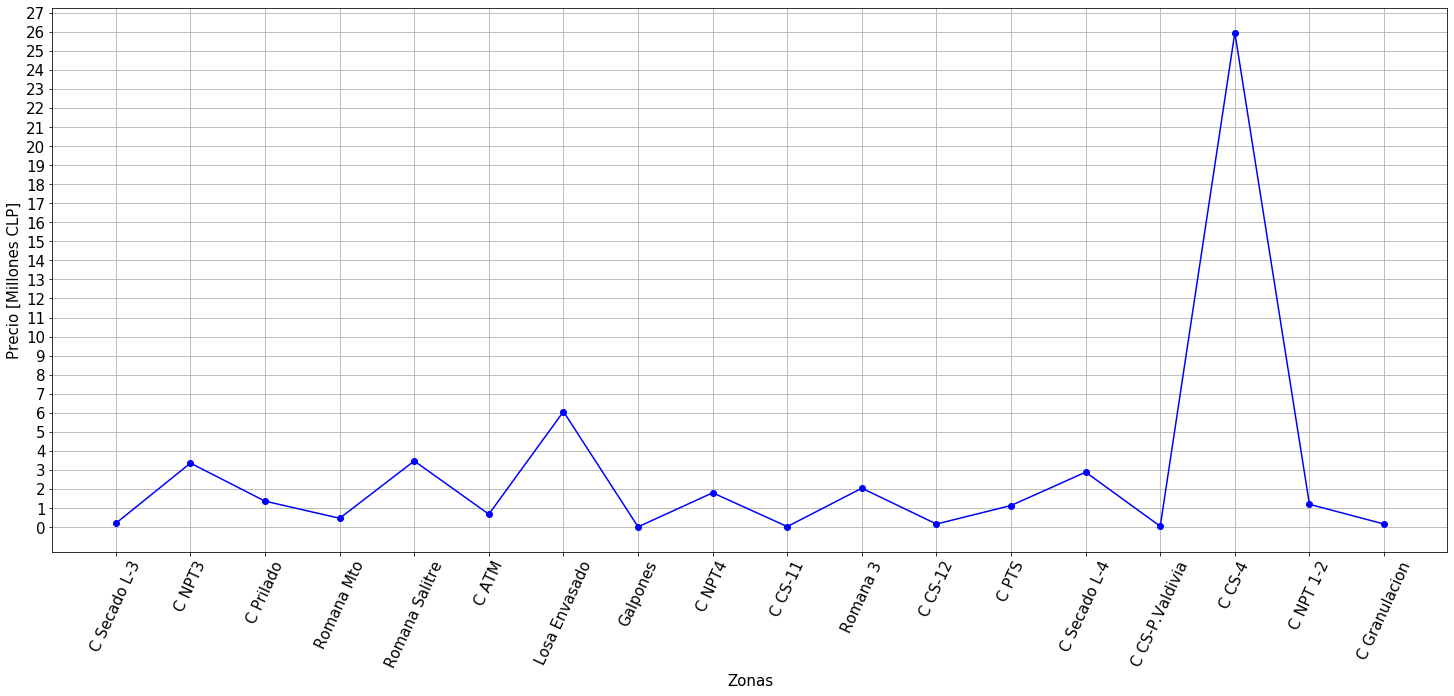

In [54]:
aux = df[df['Mes'] == 'Febrero']
plt.figure(figsize=(25,10))
plt.plot(aux['Zona'],aux['Precio Promedio [Millones CLP]'],'bo-')
plt.xlabel('Zonas',fontsize=15)
plt.ylabel('Precio [Millones CLP]',fontsize=15)
plt.xticks(aux['Zona'],fontsize=15,rotation=65)
plt.yticks(np.arange(0,28,1),fontsize=15)
plt.grid(True)
plt.show()

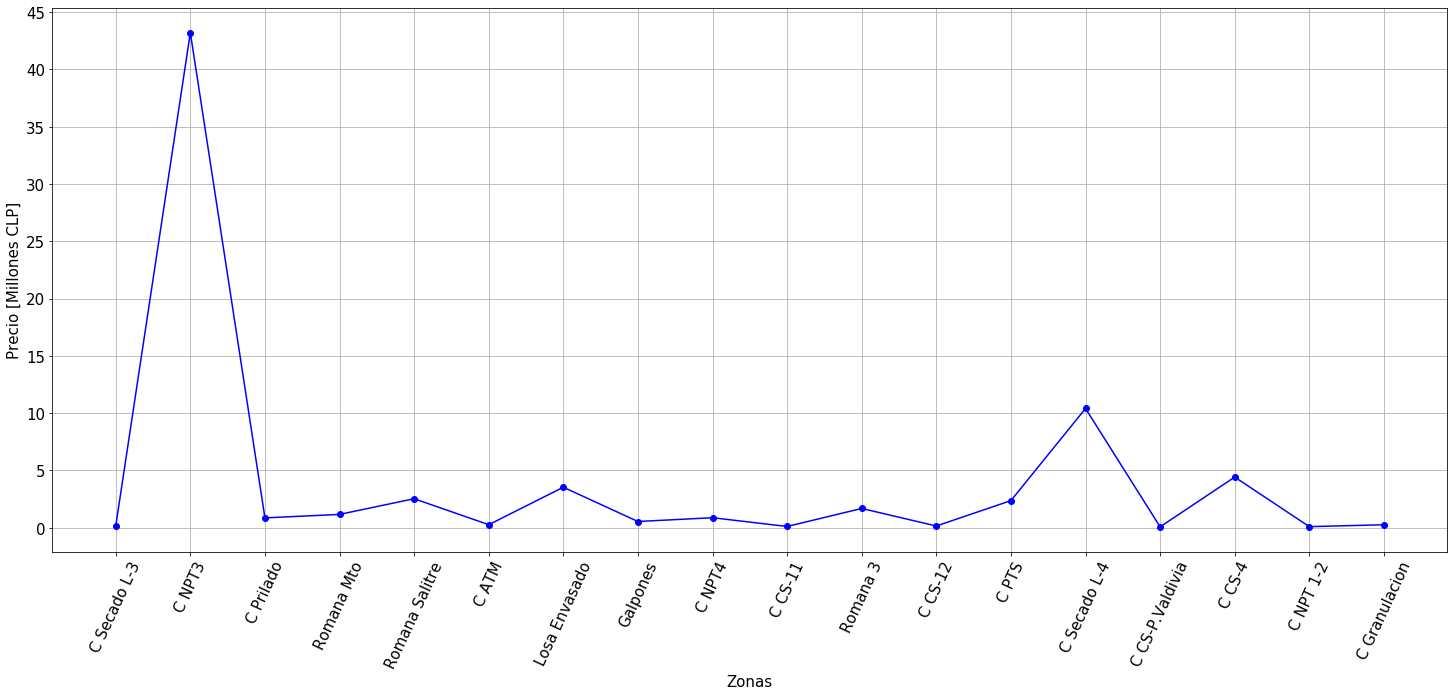

In [53]:
aux = df[df['Mes'] == 'Marzo']
plt.figure(figsize=(25,10))
plt.plot(aux['Zona'],aux['Precio Promedio [Millones CLP]'],'bo-')
plt.xlabel('Zonas',fontsize=15)
plt.ylabel('Precio [Millones CLP]',fontsize=15)
plt.xticks(aux['Zona'],fontsize=15,rotation=65)
plt.yticks(np.arange(0,50,5),fontsize=15)
plt.grid(True)
plt.show()

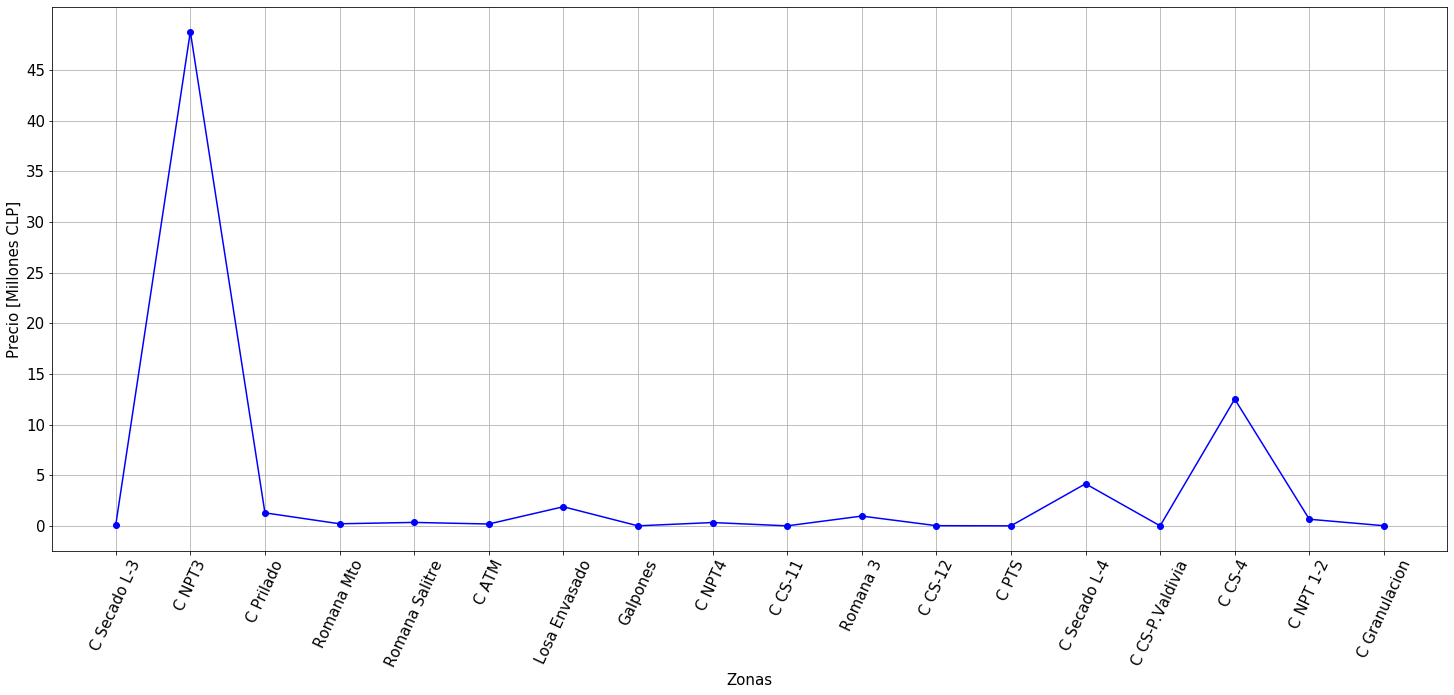

In [55]:
aux = df[df['Mes'] == 'Enero']
plt.figure(figsize=(25,10))
plt.plot(aux['Zona'],aux['Precio Promedio [Millones CLP]'],'bo-')
plt.xlabel('Zonas',fontsize=15)
plt.ylabel('Precio [Millones CLP]',fontsize=15)
plt.xticks(aux['Zona'],fontsize=15,rotation=65)
plt.yticks(np.arange(0,50,5),fontsize=15)
plt.grid(True)
plt.show()

In [61]:
df.iloc[13:24,1:]

Mes             Zona       Horas  N° Camiones  \
13    Enero     C Secado L-4  162.616667    12.508974   
14    Enero  C CS-P.Valdivia    0.000000     0.000000   
15    Enero           C CS-4  489.916667    37.685897   
16    Enero        C NPT 1-2   25.500000     1.961538   
17    Enero    C Granulacion    0.500000     0.038462   
18  Febrero     C Secado L-3    7.833333     0.602564   
19  Febrero           C NPT3  131.533333    10.117949   
20  Febrero        C Prilado   53.333333     4.102564   
21  Febrero       Romana Mto   18.133333     1.394872   
22  Febrero   Romana Salitre  135.966667    10.458974   
23  Febrero            C ATM   26.483333     2.037179   

    Precio Min [Millones CLP]  Precio Max [Millones CLP]  \
13                   3.505640                   4.797192   
14                   0.000000                   0.000000   
15                  10.561473                  14.452542   
16                   0.549721                   0.752250   
17                   0.010779                   0.014750   
18                   0.168869                   0.231083   
19                   2.835555                   3.880233   
20                   1.149744                   1.573333   
21                   0.390913                   0.534933   
22                   2.931128                   4.011017   
23                   0.570920                   0.781258   

    Precio Promedio [Millones CLP]  
13                        4.151416  
14                        0.000000  
15                       12.507007  
16                        0.650986  
17                        0.012764  
18                        0.199976  
19                        3.357894  
20                        1.361538  
21                        0.462923  
22                        3.471072  
23                        0.676089